In [202]:
# import modules
import numpy
import pandas
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as smapi
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [203]:
# load dataframe
dataframe = pandas.read_csv('amounts.csv', parse_dates=['year'], index_col=['year'])
dataframe.head()


,amount
year,
1900-01-01,100
1901-01-01,110
1902-01-01,149
1903-01-01,176
1904-01-01,201


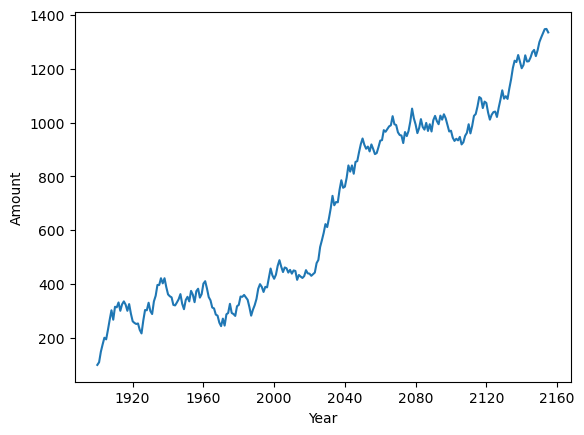

In [204]:
# plot dataframe
pyplot.xlabel('Year')
pyplot.ylabel('Amount')
pyplot.plot(dataframe)

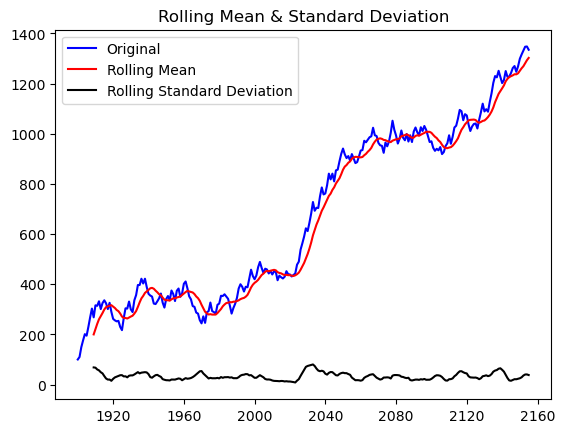

In [205]:
# calculate rolling mean and rolling standard deviation
rolling_mean = dataframe.rolling(window=10).mean()
rolling_std = dataframe.rolling(window=10).std()

# plot the new dataframes
pyplot.plot(dataframe, color='blue', label='Original')
pyplot.plot(rolling_mean, color='red', label='Rolling Mean')
pyplot.plot(rolling_std, color='black', label='Rolling Standard Deviation')
pyplot.legend(loc='best')
pyplot.title('Rolling Mean & Standard Deviation')

pyplot.show()

In [206]:
# calculate stationarity using the adfuller method
result = adfuller(dataframe['amount'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -0.13926159027152693
p-value: 0.9453847779084374
Critical Values:
	1%: -3.4562572510874396
	5%: -2.8729420379793598
	10%: -2.5728461399461744


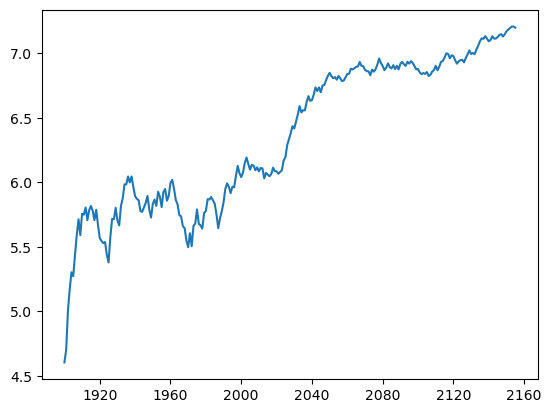

In [207]:
# use log for the dataframe
dataframe_log = numpy.log(dataframe)
pyplot.plot(dataframe_log)

In [208]:
# define function to check for stationarity
def get_stationarity(time_series):
    rolling_mean = time_series.rolling(window=10).mean()
    rolling_std = time_series.rolling(window=10).std()

    original = pyplot.plot(time_series, color='blue', label='Original')
    mean = pyplot.plot(rolling_mean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolling_std, color='black', label='Rolling Standard Deviation')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False)

    result = adfuller(time_series['amount'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

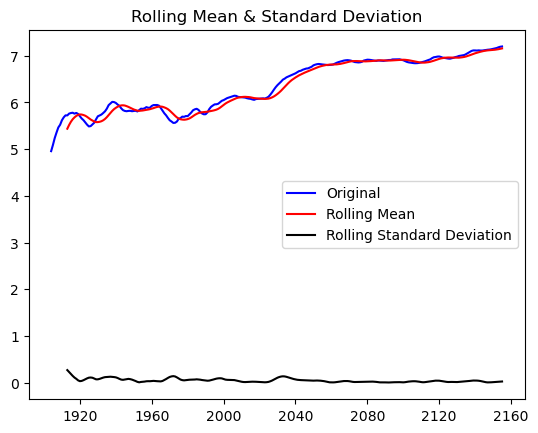

ADF Statistic: -0.3870267036902199
p-value: 0.912242423124182
Critical Values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359


In [209]:
# stationarity using rolling mean
rolling_mean = dataframe_log.rolling(window=5).mean()
dataframe_log_minus_mean = dataframe_log = rolling_mean
dataframe_log_minus_mean.dropna(inplace=True)

get_stationarity(dataframe_log_minus_mean)

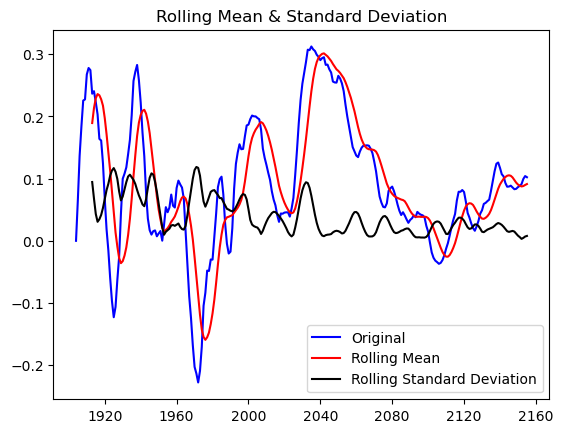

ADF Statistic: -2.1440855260479608
p-value: 0.22716085943121328
Critical Values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359


In [210]:
# stationarity using exponential decay
rolling_mean_exp_decay = dataframe_log.ewm(halflife=10, min_periods=0, adjust=True).mean()
dataframe_log_exp_decay = dataframe_log - rolling_mean_exp_decay
dataframe_log_exp_decay.dropna(inplace=True)

get_stationarity(dataframe_log_exp_decay)

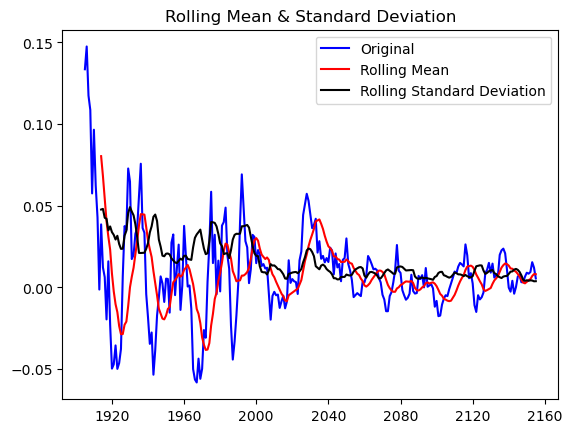

ADF Statistic: -4.144622176722902
p-value: 0.0008164956856758477
Critical Values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359


In [211]:
# stationarity using shifting
dataframe_log_shift = dataframe_log - dataframe_log.shift()
dataframe_log_shift.dropna(inplace=True)

get_stationarity(dataframe_log_shift)

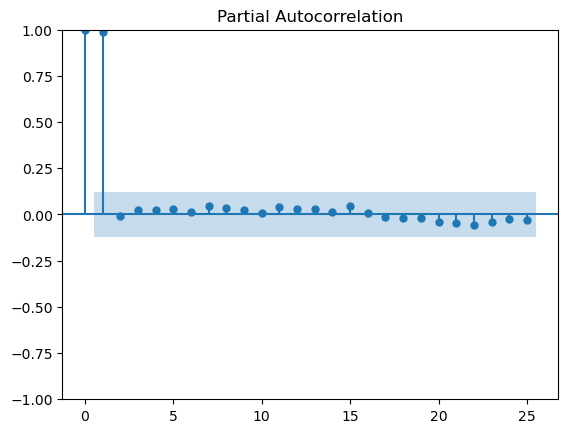

In [212]:
# create pacf plot to determine AR order
pacf_plot = plot_pacf(dataframe_log['amount'])

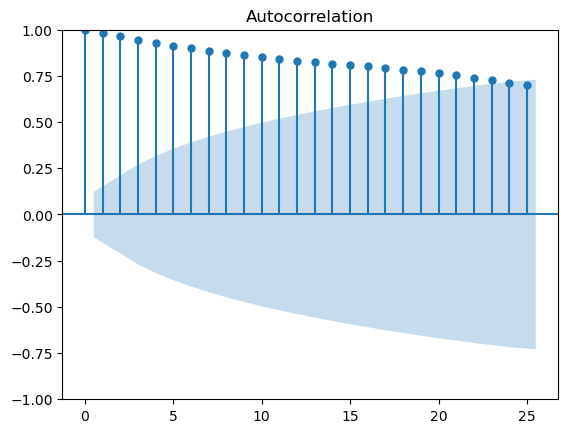

In [213]:
# create acf plot to determine MA order
acf_plot = plot_acf(dataframe_log['amount'])

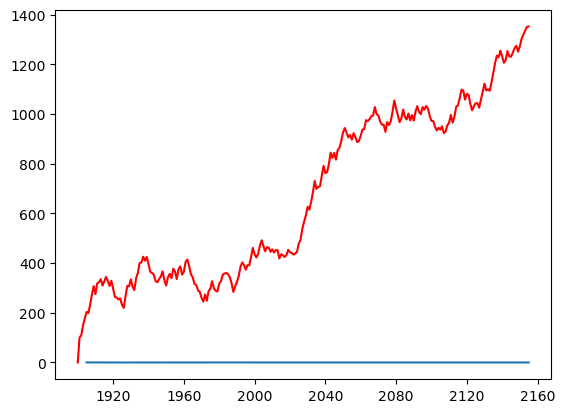

In [214]:
# fit the model
decomposition = seasonal_decompose(dataframe)
model = smapi.tsa.arima.ARIMA(dataframe, order=(2,1,2))
results = model.fit()
pyplot.plot(dataframe_log_shift)
pyplot.plot(results.fittedvalues, color='red')


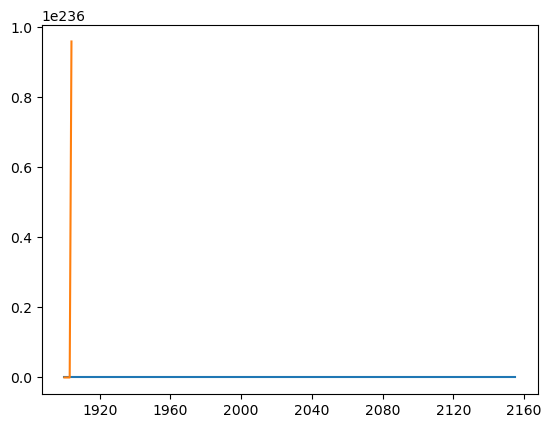

In [215]:
# calculate predictions
predictions_ARIMA_diff = pandas.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pandas.Series(dataframe_log['amount'].iloc[0], index=dataframe_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = numpy.exp(predictions_ARIMA_log)
pyplot.plot(dataframe)
pyplot.plot(predictions_ARIMA)


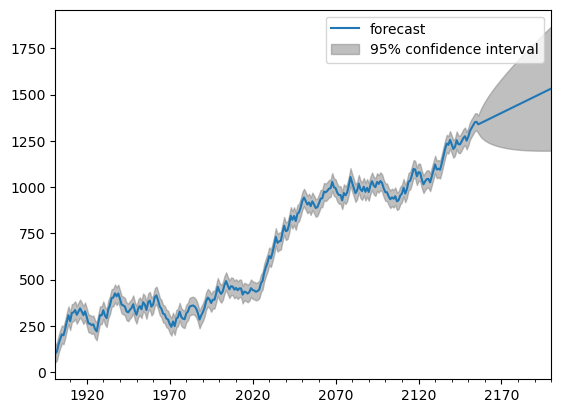

In [216]:
# plot the forecast
pred = plot_predict(results, 1, 300)